##  Butterfly Images - Pytorch

In June 2015, I read an article about tensorflow practiced on butterfly images. Just right after presenting my Master's capstone project which I changed from Convulutional Neural Networks to Enterprise Architecture. I didn't know Neural Networks were the building block of Deep Learning or the blog I read is about Deep Learning and Computer Vision.
You can find the article [here](https://www.oreilly.com/learning/a-poet-does-tensorflow) but the author didn't share the dataset plus I would love to practice on my own butterfly images, so I used my images for the below examples.
If you also want to see how he worked on his Dataset using Tensorflow, you can read his blogpost and the blogpost he is insprired from the links below:

- [Tensorflow for Poets](https://www.oreilly.com/learning/tensorflow-for-poets)

- [A Poet Does Tensorflow](https://www.oreilly.com/learning/a-poet-does-tensorflow)

Both, I loved to work on the images with Pytorch, and I didn't want to repeat the blogpost above I kept using Pytorch only.

In [2]:
# Import required libraries for this section
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import cv2

import torch
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

## Load Data

In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of data set to use as test
test_size = 0.2


transform = transforms.Compose([ transforms.Resize((256,256)), transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


data_set = dset.ImageFolder(root="data",transform=transform)
dataloader = torch.utils.data.DataLoader(data_set, batch_size=4,shuffle=True,num_workers=2)

# obtain training indices that will be used for test
num_data = len(data_set)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_data))
train_idx, test_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
test_sampler  = SubsetRandomSampler(test_idx)

# prepare data loaders
trainloader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                           sampler = train_sampler, num_workers=num_workers)
testloader  = torch.utils.data.DataLoader(data_set, batch_size=batch_size, 
                                           sampler = test_sampler, num_workers=num_workers)

classes = ('blurry','clear')

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

In [5]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

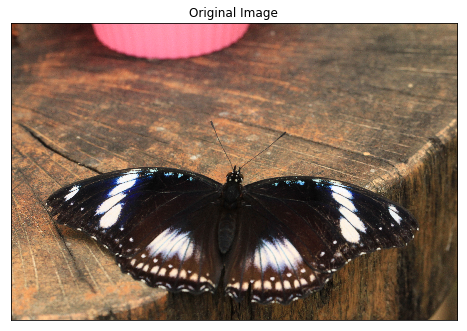

In [6]:
# Load in color image for detection
path_name = 'data/clear/IMG_6976.JPG'
image = cv2.imread(path_name)

# Convert the image to RGB colorspace
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot our image using subplots to specify a size and title
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(111)
ax1.set_xticks([])
ax1.set_yticks([])

ax1.set_title('Original Image')
ax1.imshow(image)

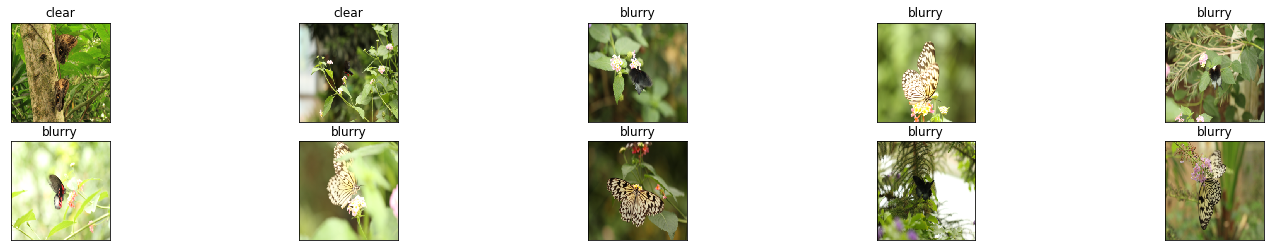

In [7]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

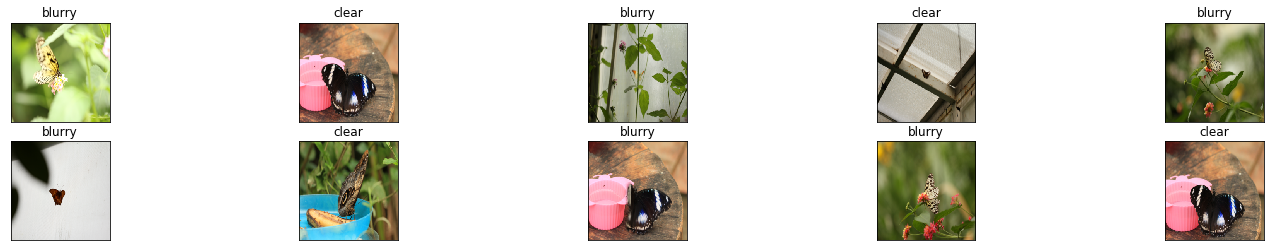

In [8]:
# obtain one batch of training images
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Train Images
Here we are defining our network architecture and training them

In [10]:
import torch.nn as nn

# Build a feed-forward network
model = nn.Sequential(nn.Linear(196608, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.2084, grad_fn=<NllLossBackward>)


In [11]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [12]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 0.0016,  0.0012, -0.0020,  ...,  0.0011,  0.0002, -0.0010],
        [ 0.0006, -0.0021,  0.0005,  ..., -0.0006,  0.0019,  0.0006],
        [-0.0014, -0.0022,  0.0005,  ...,  0.0012, -0.0007,  0.0013],
        ...,
        [-0.0002, -0.0012,  0.0003,  ..., -0.0006, -0.0005, -0.0006],
        [-0.0011, -0.0001, -0.0022,  ..., -0.0022,  0.0007, -0.0010],
        [ 0.0001, -0.0002,  0.0003,  ...,  0.0015,  0.0013, -0.0013]],
       requires_grad=True)


In [13]:
model = nn.Sequential(nn.Linear(196608, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 30
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten images into a long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.939524508786924
Training loss: 0.4849121277079438
Training loss: 0.4438447753588359
Training loss: 0.3971408228531028
Training loss: 0.34426700436707697
Training loss: 0.32480072207523114
Training loss: 0.3220954151316123
Training loss: 0.25401573424989526
Training loss: 0.2681918821551583
Training loss: 0.2636741076906522
Training loss: 0.20680260748574228
Training loss: 0.19008399388103775
Training loss: 0.16860524350495049
Training loss: 0.16121103061419545
Training loss: 0.1472159628615235
Training loss: 0.15776750535675974
Training loss: 0.13040725299806305
Training loss: 0.14394327930428766
Training loss: 0.12445219831936287
Training loss: 0.09676944616843354
Training loss: 0.09400558324925827
Training loss: 0.084768911640188
Training loss: 0.09587388958386851
Training loss: 0.08641936878363292
Training loss: 0.06647448648105968
Training loss: 0.06043724925962813
Training loss: 0.04921589678887165
Training loss: 0.04135818291229732
Training loss: 0.05661540009984

## Transfer Learning

In [14]:
from torchvision import models

## DenseNet

In [16]:
model = models.densenet121(pretrained=True)
model

/home/ayshine/anaconda3/envs/pytorch/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [15]:
transfer_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

data_set = dset.ImageFolder(root="data",transform=transfer_transforms)
dataloader = torch.utils.data.DataLoader(data_set, batch_size=4,shuffle=True,num_workers=2)

# obtain training indices that will be used for test
num_data = len(data_set)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_data))
train_idx, test_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
test_sampler  = SubsetRandomSampler(test_idx)

# prepare data loaders
trainloader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                           sampler = train_sampler, num_workers=num_workers)
testloader  = torch.utils.data.DataLoader(data_set, batch_size=batch_size, 
                                           sampler = test_sampler, num_workers=num_workers)

classes = ('blurry','clear')

In [17]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

optimizer = 

In [ ]:
model = train(100, loaders_scratch, model, optimizer_scratch, 
                           criterion_scratch, use_cuda, 'model_scratch.pt')

In [32]:
epochs = 10
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/10.. Train loss: 0.513.. Test loss: 0.516.. Test accuracy: 0.794
Epoch 1/10.. Train loss: 0.538.. Test loss: 0.627.. Test accuracy: 0.656
Epoch 1/10.. Train loss: 0.404.. Test loss: 0.474.. Test accuracy: 0.800
Epoch 1/10.. Train loss: 0.438.. Test loss: 0.449.. Test accuracy: 0.800
Epoch 1/10.. Train loss: 0.500.. Test loss: 0.462.. Test accuracy: 0.778
Epoch 1/10.. Train loss: 0.442.. Test loss: 0.467.. Test accuracy: 0.789
Epoch 2/10.. Train loss: 0.469.. Test loss: 0.442.. Test accuracy: 0.833
Epoch 2/10.. Train loss: 0.486.. Test loss: 0.438.. Test accuracy: 0.800
Epoch 2/10.. Train loss: 0.350.. Test loss: 0.421.. Test accuracy: 0.839
Epoch 2/10.. Train loss: 0.447.. Test loss: 0.445.. Test accuracy: 0.806
Epoch 2/10.. Train loss: 0.391.. Test loss: 0.685.. Test accuracy: 0.683
Epoch 2/10.. Train loss: 0.450.. Test loss: 0.394.. Test accuracy: 0.839
Epoch 2/10.. Train loss: 0.391.. Test loss: 0.485.. Test accuracy: 0.789
Epoch 3/10.. Train loss: 0.340.. Test loss: 0.366..

## Alexnet

In [20]:
alexnet_model = torchvision.models.alexnet(pretrained=True)
alexnet_model 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [28]:
# Freeze parameters so we don't backprop through them
for param in alexnet_model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(9216, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
alexnet_model.classifier = classifier

In [29]:
inputs.resize_((20,3,227,227))

tensor([[[[-0.8507, -0.8335, -0.7822,  ..., -0.8335, -0.7993, -0.7479],
          [-0.7137, -0.6794, -0.6965,  ..., -0.6965, -0.6965, -0.6965],
          [-0.6623, -0.6109, -0.5938,  ..., -0.6452, -0.6109, -0.5938],
          ...,
          [-0.4951, -0.5126, -0.5126,  ..., -0.5301, -0.5126, -0.4776],
          [-0.4601, -0.4601, -0.4601,  ..., -0.4426, -0.4426, -0.4251],
          [-0.4076, -0.3901, -0.3375,  ..., -0.3725, -0.3550, -0.3200]],

         [[-0.3025, -0.3025, -0.2325,  ..., -0.2850, -0.2500, -0.0224],
          [ 0.3277,  0.5728,  0.7304,  ...,  0.4853,  0.7129,  0.8704],
          [ 0.9755,  1.0630,  1.1681,  ...,  1.1155,  1.2206,  1.3256],
          ...,
          [-0.7587, -0.5147, -0.0964,  ..., -0.7587, -0.4101,  0.0431],
          [ 0.4091,  0.6879,  0.8274,  ...,  0.6531,  0.8622,  0.9319],
          [ 0.9668,  0.9145,  0.8971,  ...,  0.9668,  0.8274,  0.8274]],

         [[ 0.8971,  0.9668,  0.9668,  ...,  0.7751,  0.7751,  0.6879],
          [ 0.4788,  0.4265,  

In [30]:
device = torch.device( "cpu")
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

In [31]:
epochs = 10
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = alexnet_model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            alexnet_model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = alexnet_model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            alexnet_model.train()

Epoch 1/10.. Train loss: 0.747.. Test loss: 0.710.. Test accuracy: 0.456
Epoch 1/10.. Train loss: 0.730.. Test loss: 0.719.. Test accuracy: 0.444
Epoch 1/10.. Train loss: 0.713.. Test loss: 0.745.. Test accuracy: 0.428
Epoch 1/10.. Train loss: 0.747.. Test loss: 0.753.. Test accuracy: 0.389
Epoch 1/10.. Train loss: 0.786.. Test loss: 0.708.. Test accuracy: 0.433
Epoch 1/10.. Train loss: 0.708.. Test loss: 0.721.. Test accuracy: 0.411
Epoch 2/10.. Train loss: 0.754.. Test loss: 0.710.. Test accuracy: 0.500
Epoch 2/10.. Train loss: 0.761.. Test loss: 0.716.. Test accuracy: 0.433
Epoch 2/10.. Train loss: 0.729.. Test loss: 0.722.. Test accuracy: 0.500
Epoch 2/10.. Train loss: 0.705.. Test loss: 0.684.. Test accuracy: 0.611
Epoch 2/10.. Train loss: 0.749.. Test loss: 0.778.. Test accuracy: 0.383
Epoch 2/10.. Train loss: 0.721.. Test loss: 0.721.. Test accuracy: 0.433
Epoch 2/10.. Train loss: 0.740.. Test loss: 0.741.. Test accuracy: 0.311
Epoch 3/10.. Train loss: 0.725.. Test loss: 0.731..